In [1]:
!pip install torchsampler
!pip install torchmetrics
!pip install split-folders

In [2]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
from tqdm.autonotebook import tqdm, trange
import time
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix, classification_report
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import BatchSampler
import pandas as pd
import random
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, LeakyReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [3]:
import splitfolders

# Split the dataset into train, test, and val folders
splitfolders.ratio('/kaggle/input/sport-celebrity-image-classification/Sports-celebrity images', output="data1", seed=1337, ratio=(.7, 0.2, 0.1))

# Define the paths to train, test, and val folders
train_folder = "data1/train"
test_folder = "data1/test"
val_folder = "data1/val"

Copying files: 441 files [00:03, 124.66 files/s]


In [4]:
train_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),
                                       
])

val_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),
                                       
])

test_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.ToTensor(),
                                       
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root = train_folder, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_folder, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_folder, transform=test_transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=32)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=32, shuffle=False)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
model = models.resnet18(pretrained=True)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (fc) with a new one for 4 classes
num_ftrs = model.fc.in_features  # Get the number of input features to the existing fc layer
num_classes = 4  # Assuming you want to classify 4 image types
model.fc = nn.Linear(num_ftrs, num_classes)  # Replace the fc layer with a new Linear layer for 4 classes

In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
if torch.cuda.is_available() == True:
    model = model.cuda()
else:
    model = model
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler(enabled=True)
use_cuda = True

In [12]:
train_accu = []
training_loss = []

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    image_preds_all = []
    image_targets_all = []

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device).float()
        y = y.to(device).long()

        with autocast():

            y_pred = model(x)

            image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            image_targets_all += [y.detach().cpu().numpy()]

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            scaler.scale(loss).backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    score = (image_preds_all==image_targets_all).mean()

    train_losss = epoch_loss / len(iterator)

    train_accu.append(score*100)
    training_loss.append(train_losss)

    #print(score)
    #print(len(train_accu), len(training_loss))

    return epoch_loss / len(iterator), epoch_acc / len(iterator), train_accu, training_loss

In [13]:
val_accu = []
eval_loss = []

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    image_preds_all = []
    image_targets_all = []

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device).float()
            y = y.to(device).long()

            y_pred = model(x)

            image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            image_targets_all += [y.detach().cpu().numpy()]

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    score = (image_preds_all==image_targets_all).mean()

    val_losss = epoch_loss / len(iterator)

    val_accu.append(score*100)
    eval_loss.append(val_losss)

    performance_matrix(image_targets_all, image_preds_all)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_accu, eval_loss

In [14]:
def performance_matrix(true,pred):
    precision = precision_score(true,pred,average='macro')
    recall = recall_score(true,pred,average='macro')
    accuracy = accuracy_score(true,pred)
    f1_sco = f1_score(true,pred,average='macro')
    print('Precision: {:.4f} Recall: {:.4f}, Accuracy: {:.4f}: ,f1_score: {:.4f}'.format(precision,recall,accuracy,f1_sco))
    print('Classification Report:\n',classification_report(true, pred))

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
def checkpoint_model(epoch, model, opt, best_val_acc, model_path):
    model_state_dict = model.state_dict() if (device.type == 'cuda') else model.state_dict()
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_state_dict,
        'opt_state_dict': opt.state_dict(),
        'best_val_acc': best_val_acc
    }, model_path)

In [18]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    return model, optimizer, checkpoint['epoch']

The model has 2,052 trainable parameters


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.1230 Recall: 0.2451, Accuracy: 0.2442: ,f1_score: 0.1632
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.24      0.41      0.30        22
           2       0.00      0.00      0.00        20
           3       0.26      0.57      0.35        21

    accuracy                           0.24        86
   macro avg       0.12      0.25      0.16        86
weighted avg       0.12      0.24      0.16        86

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.642 | Train Acc: 23.44%
	 Val. Loss: 1.585 |  Val. Acc: 27.56%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.1995 Recall: 0.2524, Accuracy: 0.2558: ,f1_score: 0.2190
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.17      0.20        23
           1       0.33      0.45      0.38        22
           2       0.00      0.00      0.00        20
           3       0.24      0.38      0.30        21

    accuracy                           0.26        86
   macro avg       0.20      0.25      0.22        86
weighted avg       0.20      0.26      0.22        86

Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.490 | Train Acc: 20.69%
	 Val. Loss: 1.426 |  Val. Acc: 26.70%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.1941 Recall: 0.1871, Accuracy: 0.1860: ,f1_score: 0.1897
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.17      0.17        23
           1       0.12      0.14      0.13        22
           2       0.19      0.20      0.20        20
           3       0.29      0.24      0.26        21

    accuracy                           0.19        86
   macro avg       0.19      0.19      0.19        86
weighted avg       0.19      0.19      0.19        86

Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.442 | Train Acc: 23.44%
	 Val. Loss: 1.567 |  Val. Acc: 19.03%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.2559 Recall: 0.2241, Accuracy: 0.2209: ,f1_score: 0.2232
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.22      0.21        23
           1       0.12      0.09      0.10        22
           2       0.21      0.35      0.26        20
           3       0.50      0.24      0.32        21

    accuracy                           0.22        86
   macro avg       0.26      0.22      0.22        86
weighted avg       0.25      0.22      0.22        86

Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 1.425 | Train Acc: 26.62%
	 Val. Loss: 1.477 |  Val. Acc: 22.63%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.1808 Recall: 0.1649, Accuracy: 0.1628: ,f1_score: 0.1628
Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.09      0.10        23
           1       0.33      0.23      0.27        22
           2       0.12      0.25      0.16        20
           3       0.14      0.10      0.11        21

    accuracy                           0.16        86
   macro avg       0.18      0.16      0.16        86
weighted avg       0.18      0.16      0.16        86

Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 1.437 | Train Acc: 26.44%
	 Val. Loss: 1.468 |  Val. Acc: 16.00%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.2028 Recall: 0.2250, Accuracy: 0.2209: ,f1_score: 0.2083
Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.04      0.05        23
           1       0.33      0.36      0.35        22
           2       0.22      0.35      0.27        20
           3       0.19      0.14      0.16        21

    accuracy                           0.22        86
   macro avg       0.20      0.22      0.21        86
weighted avg       0.20      0.22      0.21        86

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 1.394 | Train Acc: 27.19%
	 Val. Loss: 1.477 |  Val. Acc: 21.69%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.2829 Recall: 0.2804, Accuracy: 0.2791: ,f1_score: 0.2743
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.22      0.24        23
           1       0.30      0.36      0.33        22
           2       0.25      0.35      0.29        20
           3       0.31      0.19      0.24        21

    accuracy                           0.28        86
   macro avg       0.28      0.28      0.27        86
weighted avg       0.28      0.28      0.27        86

Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 1.384 | Train Acc: 30.88%
	 Val. Loss: 1.447 |  Val. Acc: 27.37%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.2453 Recall: 0.2415, Accuracy: 0.2442: ,f1_score: 0.2350
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.39      0.33        23
           1       0.31      0.18      0.23        22
           2       0.19      0.25      0.22        20
           3       0.20      0.14      0.17        21

    accuracy                           0.24        86
   macro avg       0.25      0.24      0.23        86
weighted avg       0.25      0.24      0.24        86

Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 1.359 | Train Acc: 33.75%
	 Val. Loss: 1.425 |  Val. Acc: 23.77%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.2392 Recall: 0.2326, Accuracy: 0.2326: ,f1_score: 0.2338
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.22      0.23        23
           1       0.33      0.27      0.30        22
           2       0.19      0.25      0.21        20
           3       0.20      0.19      0.20        21

    accuracy                           0.23        86
   macro avg       0.24      0.23      0.23        86
weighted avg       0.24      0.23      0.23        86

Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 1.347 | Train Acc: 33.25%
	 Val. Loss: 1.393 |  Val. Acc: 23.20%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.2463 Recall: 0.2472, Accuracy: 0.2442: ,f1_score: 0.2376
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.13      0.17        23
           1       0.25      0.23      0.24        22
           2       0.25      0.25      0.25        20
           3       0.24      0.38      0.29        21

    accuracy                           0.24        86
   macro avg       0.25      0.25      0.24        86
weighted avg       0.25      0.24      0.24        86

Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 1.318 | Train Acc: 31.75%
	 Val. Loss: 1.379 |  Val. Acc: 26.14%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4062 Recall: 0.3623, Accuracy: 0.3605: ,f1_score: 0.3665
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.35      0.29        23
           1       0.60      0.27      0.37        22
           2       0.40      0.40      0.40        20
           3       0.38      0.43      0.40        21

    accuracy                           0.36        86
   macro avg       0.41      0.36      0.37        86
weighted avg       0.40      0.36      0.36        86

Epoch: 11 | Epoch Time: 0m 2s
	Train Loss: 1.319 | Train Acc: 35.06%
	 Val. Loss: 1.344 |  Val. Acc: 36.55%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4606 Recall: 0.3980, Accuracy: 0.3953: ,f1_score: 0.3958
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.35      0.32        23
           1       0.75      0.27      0.40        22
           2       0.42      0.40      0.41        20
           3       0.38      0.57      0.45        21

    accuracy                           0.40        86
   macro avg       0.46      0.40      0.40        86
weighted avg       0.46      0.40      0.39        86

Epoch: 12 | Epoch Time: 0m 2s
	Train Loss: 1.327 | Train Acc: 34.81%
	 Val. Loss: 1.307 |  Val. Acc: 41.57%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.3253 Recall: 0.3327, Accuracy: 0.3372: ,f1_score: 0.3218
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.30      0.32        23
           1       0.46      0.59      0.52        22
           2       0.27      0.15      0.19        20
           3       0.23      0.29      0.26        21

    accuracy                           0.34        86
   macro avg       0.33      0.33      0.32        86
weighted avg       0.33      0.34      0.33        86

Epoch: 13 | Epoch Time: 0m 2s
	Train Loss: 1.307 | Train Acc: 39.31%
	 Val. Loss: 1.309 |  Val. Acc: 33.52%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.3711 Recall: 0.3757, Accuracy: 0.3721: ,f1_score: 0.3677
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.22      0.27        23
           1       0.37      0.45      0.41        22
           2       0.41      0.45      0.43        20
           3       0.35      0.38      0.36        21

    accuracy                           0.37        86
   macro avg       0.37      0.38      0.37        86
weighted avg       0.37      0.37      0.37        86

Epoch: 14 | Epoch Time: 0m 2s
	Train Loss: 1.301 | Train Acc: 40.25%
	 Val. Loss: 1.336 |  Val. Acc: 37.59%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4099 Recall: 0.4179, Accuracy: 0.4186: ,f1_score: 0.4113
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.30      0.33        23
           1       0.52      0.64      0.57        22
           2       0.39      0.35      0.37        20
           3       0.36      0.38      0.37        21

    accuracy                           0.42        86
   macro avg       0.41      0.42      0.41        86
weighted avg       0.41      0.42      0.41        86

Epoch: 15 | Epoch Time: 0m 2s
	Train Loss: 1.268 | Train Acc: 43.19%
	 Val. Loss: 1.299 |  Val. Acc: 41.76%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.3952 Recall: 0.3961, Accuracy: 0.3953: ,f1_score: 0.3821
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.52      0.45        23
           1       0.40      0.18      0.25        22
           2       0.40      0.50      0.44        20
           3       0.38      0.38      0.38        21

    accuracy                           0.40        86
   macro avg       0.40      0.40      0.38        86
weighted avg       0.40      0.40      0.38        86

Epoch: 16 | Epoch Time: 0m 2s
	Train Loss: 1.293 | Train Acc: 36.19%
	 Val. Loss: 1.329 |  Val. Acc: 39.68%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4426 Recall: 0.4338, Accuracy: 0.4302: ,f1_score: 0.4323
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.30      0.35        23
           1       0.61      0.50      0.55        22
           2       0.44      0.55      0.49        20
           3       0.31      0.38      0.34        21

    accuracy                           0.43        86
   macro avg       0.44      0.43      0.43        86
weighted avg       0.44      0.43      0.43        86

Epoch: 17 | Epoch Time: 0m 2s
	Train Loss: 1.259 | Train Acc: 43.19%
	 Val. Loss: 1.316 |  Val. Acc: 42.80%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4214 Recall: 0.4090, Accuracy: 0.4070: ,f1_score: 0.4045
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.43      0.39        23
           1       0.50      0.27      0.35        22
           2       0.40      0.50      0.44        20
           3       0.43      0.43      0.43        21

    accuracy                           0.41        86
   macro avg       0.42      0.41      0.40        86
weighted avg       0.42      0.41      0.40        86

Epoch: 18 | Epoch Time: 0m 2s
	Train Loss: 1.251 | Train Acc: 46.13%
	 Val. Loss: 1.267 |  Val. Acc: 41.19%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5461 Recall: 0.5186, Accuracy: 0.5233: ,f1_score: 0.5168
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.74      0.57        23
           1       0.60      0.41      0.49        22
           2       0.50      0.45      0.47        20
           3       0.62      0.48      0.54        21

    accuracy                           0.52        86
   macro avg       0.55      0.52      0.52        86
weighted avg       0.55      0.52      0.52        86

Epoch: 19 | Epoch Time: 0m 2s
	Train Loss: 1.250 | Train Acc: 44.88%
	 Val. Loss: 1.218 |  Val. Acc: 52.08%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.3966 Recall: 0.3906, Accuracy: 0.3953: ,f1_score: 0.3861
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.57      0.50        23
           1       0.47      0.41      0.44        22
           2       0.28      0.35      0.31        20
           3       0.38      0.24      0.29        21

    accuracy                           0.40        86
   macro avg       0.40      0.39      0.39        86
weighted avg       0.40      0.40      0.39        86

Epoch: 20 | Epoch Time: 0m 2s
	Train Loss: 1.224 | Train Acc: 49.75%
	 Val. Loss: 1.262 |  Val. Acc: 37.78%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4188 Recall: 0.4182, Accuracy: 0.4186: ,f1_score: 0.4133
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.43      0.43        23
           1       0.55      0.50      0.52        22
           2       0.36      0.50      0.42        20
           3       0.33      0.24      0.28        21

    accuracy                           0.42        86
   macro avg       0.42      0.42      0.41        86
weighted avg       0.42      0.42      0.42        86

Epoch: 21 | Epoch Time: 0m 2s
	Train Loss: 1.223 | Train Acc: 50.50%
	 Val. Loss: 1.233 |  Val. Acc: 40.34%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4295 Recall: 0.4175, Accuracy: 0.4186: ,f1_score: 0.4135
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.43      0.41        23
           1       0.53      0.36      0.43        22
           2       0.40      0.30      0.34        20
           3       0.40      0.57      0.47        21

    accuracy                           0.42        86
   macro avg       0.43      0.42      0.41        86
weighted avg       0.43      0.42      0.41        86

Epoch: 22 | Epoch Time: 0m 2s
	Train Loss: 1.224 | Train Acc: 48.94%
	 Val. Loss: 1.246 |  Val. Acc: 43.18%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5258 Recall: 0.5109, Accuracy: 0.5116: ,f1_score: 0.5128
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.57      0.51        23
           1       0.62      0.45      0.53        22
           2       0.43      0.50      0.47        20
           3       0.58      0.52      0.55        21

    accuracy                           0.51        86
   macro avg       0.53      0.51      0.51        86
weighted avg       0.53      0.51      0.51        86

Epoch: 23 | Epoch Time: 0m 2s
	Train Loss: 1.181 | Train Acc: 50.50%
	 Val. Loss: 1.216 |  Val. Acc: 51.04%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4915 Recall: 0.4809, Accuracy: 0.4767: ,f1_score: 0.4788
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.30      0.34        23
           1       0.71      0.55      0.62        22
           2       0.39      0.55      0.46        20
           3       0.48      0.52      0.50        21

    accuracy                           0.48        86
   macro avg       0.49      0.48      0.48        86
weighted avg       0.49      0.48      0.48        86

Epoch: 24 | Epoch Time: 0m 2s
	Train Loss: 1.172 | Train Acc: 54.81%
	 Val. Loss: 1.229 |  Val. Acc: 48.39%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5217 Recall: 0.5055, Accuracy: 0.5000: ,f1_score: 0.5018
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.39      0.39        23
           1       0.69      0.41      0.51        22
           2       0.54      0.65      0.59        20
           3       0.46      0.57      0.51        21

    accuracy                           0.50        86
   macro avg       0.52      0.51      0.50        86
weighted avg       0.52      0.50      0.50        86

Epoch: 25 | Epoch Time: 0m 2s
	Train Loss: 1.182 | Train Acc: 54.63%
	 Val. Loss: 1.211 |  Val. Acc: 50.95%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.4700 Recall: 0.4508, Accuracy: 0.4535: ,f1_score: 0.4502
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.57      0.47        23
           1       0.53      0.45      0.49        22
           2       0.41      0.45      0.43        20
           3       0.54      0.33      0.41        21

    accuracy                           0.45        86
   macro avg       0.47      0.45      0.45        86
weighted avg       0.47      0.45      0.45        86

Epoch: 26 | Epoch Time: 0m 2s
	Train Loss: 1.141 | Train Acc: 57.00%
	 Val. Loss: 1.217 |  Val. Acc: 44.41%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5807 Recall: 0.5761, Accuracy: 0.5698: ,f1_score: 0.5663
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.48      0.51        23
           1       0.62      0.45      0.53        22
           2       0.52      0.80      0.63        20
           3       0.63      0.57      0.60        21

    accuracy                           0.57        86
   macro avg       0.58      0.58      0.57        86
weighted avg       0.58      0.57      0.56        86

Epoch: 27 | Epoch Time: 0m 2s
	Train Loss: 1.145 | Train Acc: 57.06%
	 Val. Loss: 1.163 |  Val. Acc: 57.20%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5000 Recall: 0.4907, Accuracy: 0.4884: ,f1_score: 0.4891
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.43      0.42        23
           1       0.60      0.41      0.49        22
           2       0.50      0.50      0.50        20
           3       0.50      0.62      0.55        21

    accuracy                           0.49        86
   macro avg       0.50      0.49      0.49        86
weighted avg       0.50      0.49      0.49        86

Epoch: 28 | Epoch Time: 0m 2s
	Train Loss: 1.112 | Train Acc: 61.00%
	 Val. Loss: 1.173 |  Val. Acc: 50.38%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6506 Recall: 0.6420, Accuracy: 0.6395: ,f1_score: 0.6355
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.57      0.62        23
           1       0.71      0.55      0.62        22
           2       0.63      0.60      0.62        20
           3       0.58      0.86      0.69        21

    accuracy                           0.64        86
   macro avg       0.65      0.64      0.64        86
weighted avg       0.65      0.64      0.64        86

Epoch: 29 | Epoch Time: 0m 2s
	Train Loss: 1.122 | Train Acc: 61.63%
	 Val. Loss: 1.117 |  Val. Acc: 66.29%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5798 Recall: 0.5650, Accuracy: 0.5581: ,f1_score: 0.5568
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.39      0.44        23
           1       0.71      0.45      0.56        22
           2       0.64      0.70      0.67        20
           3       0.47      0.71      0.57        21

    accuracy                           0.56        86
   macro avg       0.58      0.57      0.56        86
weighted avg       0.58      0.56      0.55        86

Epoch: 30 | Epoch Time: 0m 2s
	Train Loss: 1.133 | Train Acc: 58.13%
	 Val. Loss: 1.122 |  Val. Acc: 57.58%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6143 Recall: 0.6153, Accuracy: 0.6163: ,f1_score: 0.6126
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.57      0.59        23
           1       0.62      0.68      0.65        22
           2       0.59      0.50      0.54        20
           3       0.62      0.71      0.67        21

    accuracy                           0.62        86
   macro avg       0.61      0.62      0.61        86
weighted avg       0.61      0.62      0.61        86

Epoch: 31 | Epoch Time: 0m 2s
	Train Loss: 1.114 | Train Acc: 62.88%
	 Val. Loss: 1.123 |  Val. Acc: 62.31%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5257 Recall: 0.5239, Accuracy: 0.5233: ,f1_score: 0.5194
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.48      0.52        23
           1       0.61      0.64      0.62        22
           2       0.44      0.60      0.51        20
           3       0.47      0.38      0.42        21

    accuracy                           0.52        86
   macro avg       0.53      0.52      0.52        86
weighted avg       0.53      0.52      0.52        86

Epoch: 32 | Epoch Time: 0m 2s
	Train Loss: 1.125 | Train Acc: 57.75%
	 Val. Loss: 1.165 |  Val. Acc: 51.14%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5637 Recall: 0.5521, Accuracy: 0.5465: ,f1_score: 0.5441
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.43      0.51        23
           1       0.61      0.50      0.55        22
           2       0.47      0.75      0.58        20
           3       0.55      0.52      0.54        21

    accuracy                           0.55        86
   macro avg       0.56      0.55      0.54        86
weighted avg       0.57      0.55      0.54        86

Epoch: 33 | Epoch Time: 0m 2s
	Train Loss: 1.102 | Train Acc: 58.81%
	 Val. Loss: 1.147 |  Val. Acc: 54.64%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6540 Recall: 0.6453, Accuracy: 0.6395: ,f1_score: 0.6427
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49        23
           1       0.82      0.64      0.72        22
           2       0.59      0.80      0.68        20
           3       0.70      0.67      0.68        21

    accuracy                           0.64        86
   macro avg       0.65      0.65      0.64        86
weighted avg       0.65      0.64      0.64        86

Epoch: 34 | Epoch Time: 0m 2s
	Train Loss: 1.082 | Train Acc: 63.69%
	 Val. Loss: 1.059 |  Val. Acc: 64.39%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6416 Recall: 0.6058, Accuracy: 0.6047: ,f1_score: 0.6094
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.61      0.58        23
           1       0.92      0.55      0.69        22
           2       0.54      0.65      0.59        20
           3       0.54      0.62      0.58        21

    accuracy                           0.60        86
   macro avg       0.64      0.61      0.61        86
weighted avg       0.64      0.60      0.61        86

Epoch: 35 | Epoch Time: 0m 2s
	Train Loss: 1.051 | Train Acc: 67.94%
	 Val. Loss: 1.070 |  Val. Acc: 60.80%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6599 Recall: 0.6493, Accuracy: 0.6512: ,f1_score: 0.6491
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.78      0.69        23
           1       0.71      0.55      0.62        22
           2       0.72      0.65      0.68        20
           3       0.59      0.62      0.60        21

    accuracy                           0.65        86
   macro avg       0.66      0.65      0.65        86
weighted avg       0.66      0.65      0.65        86

Epoch: 36 | Epoch Time: 0m 2s
	Train Loss: 1.046 | Train Acc: 65.31%
	 Val. Loss: 1.102 |  Val. Acc: 64.96%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7148 Recall: 0.6962, Accuracy: 0.6977: ,f1_score: 0.6997
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.70      0.64        23
           1       0.80      0.73      0.76        22
           2       0.80      0.60      0.69        20
           3       0.67      0.76      0.71        21

    accuracy                           0.70        86
   macro avg       0.71      0.70      0.70        86
weighted avg       0.71      0.70      0.70        86

Epoch: 37 | Epoch Time: 0m 2s
	Train Loss: 1.048 | Train Acc: 64.63%
	 Val. Loss: 1.038 |  Val. Acc: 70.55%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7044 Recall: 0.6979, Accuracy: 0.6977: ,f1_score: 0.6988
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76        23
           1       0.62      0.68      0.65        22
           2       0.64      0.70      0.67        20
           3       0.71      0.71      0.71        21

    accuracy                           0.70        86
   macro avg       0.70      0.70      0.70        86
weighted avg       0.71      0.70      0.70        86

Epoch: 38 | Epoch Time: 0m 2s
	Train Loss: 1.099 | Train Acc: 57.50%
	 Val. Loss: 1.047 |  Val. Acc: 70.08%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6279 Recall: 0.5997, Accuracy: 0.5930: ,f1_score: 0.5876
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.39      0.53        23
           1       0.60      0.55      0.57        22
           2       0.56      0.70      0.62        20
           3       0.53      0.76      0.63        21

    accuracy                           0.59        86
   macro avg       0.63      0.60      0.59        86
weighted avg       0.63      0.59      0.59        86

Epoch: 39 | Epoch Time: 0m 2s
	Train Loss: 1.063 | Train Acc: 68.63%
	 Val. Loss: 1.082 |  Val. Acc: 61.17%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6509 Recall: 0.6225, Accuracy: 0.6163: ,f1_score: 0.6158
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.43      0.54        23
           1       0.81      0.59      0.68        22
           2       0.50      0.75      0.60        20
           3       0.58      0.71      0.64        21

    accuracy                           0.62        86
   macro avg       0.65      0.62      0.62        86
weighted avg       0.66      0.62      0.61        86

Epoch: 40 | Epoch Time: 0m 2s
	Train Loss: 1.056 | Train Acc: 65.25%
	 Val. Loss: 1.084 |  Val. Acc: 62.78%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6688 Recall: 0.6654, Accuracy: 0.6628: ,f1_score: 0.6641
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.57      0.58        23
           1       0.80      0.73      0.76        22
           2       0.60      0.75      0.67        20
           3       0.68      0.62      0.65        21

    accuracy                           0.66        86
   macro avg       0.67      0.67      0.66        86
weighted avg       0.67      0.66      0.66        86

Epoch: 41 | Epoch Time: 0m 2s
	Train Loss: 1.036 | Train Acc: 64.81%
	 Val. Loss: 1.031 |  Val. Acc: 66.00%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6225 Recall: 0.6140, Accuracy: 0.6163: ,f1_score: 0.6148
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.74      0.67        23
           1       0.55      0.55      0.55        22
           2       0.63      0.60      0.62        20
           3       0.71      0.57      0.63        21

    accuracy                           0.62        86
   macro avg       0.62      0.61      0.61        86
weighted avg       0.62      0.62      0.62        86

Epoch: 42 | Epoch Time: 0m 2s
	Train Loss: 1.002 | Train Acc: 67.06%
	 Val. Loss: 1.087 |  Val. Acc: 61.36%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6341 Recall: 0.6122, Accuracy: 0.6163: ,f1_score: 0.6168
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.65      0.56        23
           1       0.81      0.77      0.79        22
           2       0.56      0.50      0.53        20
           3       0.69      0.52      0.59        21

    accuracy                           0.62        86
   macro avg       0.63      0.61      0.62        86
weighted avg       0.63      0.62      0.62        86

Epoch: 43 | Epoch Time: 0m 2s
	Train Loss: 1.022 | Train Acc: 65.56%
	 Val. Loss: 1.039 |  Val. Acc: 60.89%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6864 Recall: 0.6893, Accuracy: 0.6860: ,f1_score: 0.6873
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61        23
           1       0.70      0.73      0.71        22
           2       0.81      0.85      0.83        20
           3       0.63      0.57      0.60        21

    accuracy                           0.69        86
   macro avg       0.69      0.69      0.69        86
weighted avg       0.68      0.69      0.68        86

Epoch: 44 | Epoch Time: 0m 2s
	Train Loss: 1.007 | Train Acc: 63.38%
	 Val. Loss: 1.007 |  Val. Acc: 67.61%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6861 Recall: 0.6714, Accuracy: 0.6744: ,f1_score: 0.6734
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.78      0.68        23
           1       0.78      0.64      0.70        22
           2       0.67      0.60      0.63        20
           3       0.70      0.67      0.68        21

    accuracy                           0.67        86
   macro avg       0.69      0.67      0.67        86
weighted avg       0.69      0.67      0.67        86

Epoch: 45 | Epoch Time: 0m 2s
	Train Loss: 0.953 | Train Acc: 72.13%
	 Val. Loss: 1.026 |  Val. Acc: 67.05%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7006 Recall: 0.6846, Accuracy: 0.6860: ,f1_score: 0.6832
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.78      0.69        23
           1       0.71      0.68      0.70        22
           2       0.68      0.75      0.71        20
           3       0.79      0.52      0.63        21

    accuracy                           0.69        86
   macro avg       0.70      0.68      0.68        86
weighted avg       0.70      0.69      0.68        86

Epoch: 46 | Epoch Time: 0m 2s
	Train Loss: 0.992 | Train Acc: 66.75%
	 Val. Loss: 1.025 |  Val. Acc: 67.14%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7617 Recall: 0.7441, Accuracy: 0.7442: ,f1_score: 0.7471
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.74      0.67        23
           1       0.90      0.82      0.86        22
           2       0.73      0.80      0.76        20
           3       0.81      0.62      0.70        21

    accuracy                           0.74        86
   macro avg       0.76      0.74      0.75        86
weighted avg       0.76      0.74      0.75        86

Epoch: 47 | Epoch Time: 0m 2s
	Train Loss: 1.050 | Train Acc: 61.44%
	 Val. Loss: 1.001 |  Val. Acc: 73.30%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.5897 Recall: 0.5700, Accuracy: 0.5698: ,f1_score: 0.5735
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.61      0.58        23
           1       0.69      0.50      0.58        22
           2       0.67      0.60      0.63        20
           3       0.44      0.57      0.50        21

    accuracy                           0.57        86
   macro avg       0.59      0.57      0.57        86
weighted avg       0.59      0.57      0.57        86

Epoch: 48 | Epoch Time: 0m 2s
	Train Loss: 0.966 | Train Acc: 69.94%
	 Val. Loss: 1.021 |  Val. Acc: 57.20%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6634 Recall: 0.6400, Accuracy: 0.6395: ,f1_score: 0.6432
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.70      0.62        23
           1       0.80      0.55      0.65        22
           2       0.74      0.70      0.72        20
           3       0.57      0.62      0.59        21

    accuracy                           0.64        86
   macro avg       0.66      0.64      0.64        86
weighted avg       0.66      0.64      0.64        86

Epoch: 49 | Epoch Time: 0m 2s
	Train Loss: 0.983 | Train Acc: 65.31%
	 Val. Loss: 0.999 |  Val. Acc: 63.45%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7431 Recall: 0.7321, Accuracy: 0.7326: ,f1_score: 0.7358
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.74      0.68        23
           1       0.81      0.77      0.79        22
           2       0.83      0.75      0.79        20
           3       0.70      0.67      0.68        21

    accuracy                           0.73        86
   macro avg       0.74      0.73      0.74        86
weighted avg       0.74      0.73      0.73        86

Epoch: 50 | Epoch Time: 0m 2s
	Train Loss: 0.972 | Train Acc: 72.06%
	 Val. Loss: 0.945 |  Val. Acc: 72.73%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6831 Recall: 0.6754, Accuracy: 0.6744: ,f1_score: 0.6725
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.81      0.59      0.68        22
           2       0.64      0.80      0.71        20
           3       0.57      0.57      0.57        21

    accuracy                           0.67        86
   macro avg       0.68      0.68      0.67        86
weighted avg       0.69      0.67      0.67        86

Epoch: 51 | Epoch Time: 0m 2s
	Train Loss: 0.969 | Train Acc: 69.81%
	 Val. Loss: 0.988 |  Val. Acc: 66.57%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6940 Recall: 0.6872, Accuracy: 0.6860: ,f1_score: 0.6868
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.70      0.65        23
           1       0.83      0.68      0.75        22
           2       0.70      0.80      0.74        20
           3       0.63      0.57      0.60        21

    accuracy                           0.69        86
   macro avg       0.69      0.69      0.69        86
weighted avg       0.69      0.69      0.69        86

Epoch: 52 | Epoch Time: 0m 2s
	Train Loss: 0.942 | Train Acc: 72.94%
	 Val. Loss: 0.944 |  Val. Acc: 67.61%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7185 Recall: 0.7109, Accuracy: 0.7093: ,f1_score: 0.7123
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.67        23
           1       0.84      0.73      0.78        22
           2       0.75      0.75      0.75        20
           3       0.60      0.71      0.65        21

    accuracy                           0.71        86
   macro avg       0.72      0.71      0.71        86
weighted avg       0.72      0.71      0.71        86

Epoch: 53 | Epoch Time: 0m 2s
	Train Loss: 0.952 | Train Acc: 71.63%
	 Val. Loss: 0.940 |  Val. Acc: 71.12%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7326 Recall: 0.7272, Accuracy: 0.7209: ,f1_score: 0.7209
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.57      0.63        23
           1       0.78      0.64      0.70        22
           2       0.81      0.85      0.83        20
           3       0.62      0.86      0.72        21

    accuracy                           0.72        86
   macro avg       0.73      0.73      0.72        86
weighted avg       0.73      0.72      0.72        86

Epoch: 54 | Epoch Time: 0m 2s
	Train Loss: 0.974 | Train Acc: 67.81%
	 Val. Loss: 0.958 |  Val. Acc: 73.58%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7287 Recall: 0.7229, Accuracy: 0.7209: ,f1_score: 0.7209
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71        23
           1       0.82      0.64      0.72        22
           2       0.62      0.75      0.68        20
           3       0.74      0.81      0.77        21

    accuracy                           0.72        86
   macro avg       0.73      0.72      0.72        86
weighted avg       0.73      0.72      0.72        86

Epoch: 55 | Epoch Time: 0m 2s
	Train Loss: 0.932 | Train Acc: 73.69%
	 Val. Loss: 0.930 |  Val. Acc: 73.11%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6872 Recall: 0.6802, Accuracy: 0.6744: ,f1_score: 0.6728
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61        23
           1       0.79      0.50      0.61        22
           2       0.74      0.85      0.79        20
           3       0.62      0.76      0.68        21

    accuracy                           0.67        86
   macro avg       0.69      0.68      0.67        86
weighted avg       0.69      0.67      0.67        86

Epoch: 56 | Epoch Time: 0m 2s
	Train Loss: 0.920 | Train Acc: 74.56%
	 Val. Loss: 0.969 |  Val. Acc: 68.47%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7118 Recall: 0.6922, Accuracy: 0.6860: ,f1_score: 0.6724
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71        23
           1       0.80      0.36      0.50        22
           2       0.58      0.90      0.71        20
           3       0.74      0.81      0.77        21

    accuracy                           0.69        86
   macro avg       0.71      0.69      0.67        86
weighted avg       0.71      0.69      0.67        86

Epoch: 57 | Epoch Time: 0m 2s
	Train Loss: 0.906 | Train Acc: 74.38%
	 Val. Loss: 0.951 |  Val. Acc: 69.98%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7458 Recall: 0.7267, Accuracy: 0.7209: ,f1_score: 0.7226
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67        23
           1       0.82      0.64      0.72        22
           2       0.58      0.90      0.71        20
           3       0.84      0.76      0.80        21

    accuracy                           0.72        86
   macro avg       0.75      0.73      0.72        86
weighted avg       0.75      0.72      0.72        86

Epoch: 58 | Epoch Time: 0m 2s
	Train Loss: 0.941 | Train Acc: 70.44%
	 Val. Loss: 0.953 |  Val. Acc: 72.63%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6604 Recall: 0.6550, Accuracy: 0.6512: ,f1_score: 0.6511
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.52      0.59        23
           1       0.74      0.64      0.68        22
           2       0.67      0.70      0.68        20
           3       0.57      0.76      0.65        21

    accuracy                           0.65        86
   macro avg       0.66      0.66      0.65        86
weighted avg       0.66      0.65      0.65        86

Epoch: 59 | Epoch Time: 0m 2s
	Train Loss: 0.883 | Train Acc: 74.06%
	 Val. Loss: 0.964 |  Val. Acc: 66.38%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7271 Recall: 0.7240, Accuracy: 0.7209: ,f1_score: 0.7228
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65        23
           1       0.83      0.68      0.75        22
           2       0.73      0.80      0.76        20
           3       0.70      0.76      0.73        21

    accuracy                           0.72        86
   macro avg       0.73      0.72      0.72        86
weighted avg       0.73      0.72      0.72        86

Epoch: 60 | Epoch Time: 0m 2s
	Train Loss: 0.915 | Train Acc: 69.81%
	 Val. Loss: 0.893 |  Val. Acc: 72.63%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7488 Recall: 0.7472, Accuracy: 0.7442: ,f1_score: 0.7440
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71        23
           1       0.80      0.73      0.76        22
           2       0.67      0.80      0.73        20
           3       0.74      0.81      0.77        21

    accuracy                           0.74        86
   macro avg       0.75      0.75      0.74        86
weighted avg       0.75      0.74      0.74        86

Epoch: 61 | Epoch Time: 0m 2s
	Train Loss: 0.921 | Train Acc: 71.00%
	 Val. Loss: 0.929 |  Val. Acc: 75.19%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7856 Recall: 0.7788, Accuracy: 0.7791: ,f1_score: 0.7795
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78        23
           1       0.84      0.73      0.78        22
           2       0.73      0.80      0.76        20
           3       0.84      0.76      0.80        21

    accuracy                           0.78        86
   macro avg       0.79      0.78      0.78        86
weighted avg       0.79      0.78      0.78        86

Epoch: 62 | Epoch Time: 0m 2s
	Train Loss: 0.905 | Train Acc: 71.63%
	 Val. Loss: 0.885 |  Val. Acc: 77.84%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7844 Recall: 0.7669, Accuracy: 0.7674: ,f1_score: 0.7705
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.83      0.73        23
           1       0.80      0.73      0.76        22
           2       0.80      0.80      0.80        20
           3       0.88      0.71      0.79        21

    accuracy                           0.77        86
   macro avg       0.78      0.77      0.77        86
weighted avg       0.78      0.77      0.77        86

Epoch: 63 | Epoch Time: 0m 2s
	Train Loss: 0.904 | Train Acc: 72.13%
	 Val. Loss: 0.870 |  Val. Acc: 76.33%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7401 Recall: 0.7332, Accuracy: 0.7326: ,f1_score: 0.7350
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.74      0.69        23
           1       0.75      0.68      0.71        22
           2       0.71      0.75      0.73        20
           3       0.84      0.76      0.80        21

    accuracy                           0.73        86
   macro avg       0.74      0.73      0.73        86
weighted avg       0.74      0.73      0.73        86

Epoch: 64 | Epoch Time: 0m 2s
	Train Loss: 0.929 | Train Acc: 71.06%
	 Val. Loss: 0.904 |  Val. Acc: 73.67%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7393 Recall: 0.7320, Accuracy: 0.7326: ,f1_score: 0.7340
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67        23
           1       0.75      0.82      0.78        22
           2       0.78      0.70      0.74        20
           3       0.79      0.71      0.75        21

    accuracy                           0.73        86
   macro avg       0.74      0.73      0.73        86
weighted avg       0.74      0.73      0.73        86

Epoch: 65 | Epoch Time: 0m 2s
	Train Loss: 0.910 | Train Acc: 71.69%
	 Val. Loss: 0.898 |  Val. Acc: 73.20%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6972 Recall: 0.6973, Accuracy: 0.6977: ,f1_score: 0.6967
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71        23
           1       0.68      0.68      0.68        22
           2       0.68      0.65      0.67        20
           3       0.70      0.76      0.73        21

    accuracy                           0.70        86
   macro avg       0.70      0.70      0.70        86
weighted avg       0.70      0.70      0.70        86

Epoch: 66 | Epoch Time: 0m 2s
	Train Loss: 0.882 | Train Acc: 72.31%
	 Val. Loss: 0.914 |  Val. Acc: 70.55%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7669 Recall: 0.7446, Accuracy: 0.7442: ,f1_score: 0.7505
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.74      0.68        23
           1       0.89      0.73      0.80        22
           2       0.88      0.75      0.81        20
           3       0.67      0.76      0.71        21

    accuracy                           0.74        86
   macro avg       0.77      0.74      0.75        86
weighted avg       0.76      0.74      0.75        86

Epoch: 67 | Epoch Time: 0m 2s
	Train Loss: 0.885 | Train Acc: 71.88%
	 Val. Loss: 0.864 |  Val. Acc: 74.72%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7606 Recall: 0.7577, Accuracy: 0.7558: ,f1_score: 0.7574
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71        23
           1       0.80      0.73      0.76        22
           2       0.77      0.85      0.81        20
           3       0.79      0.71      0.75        21

    accuracy                           0.76        86
   macro avg       0.76      0.76      0.76        86
weighted avg       0.76      0.76      0.76        86

Epoch: 68 | Epoch Time: 0m 2s
	Train Loss: 0.897 | Train Acc: 70.31%
	 Val. Loss: 0.874 |  Val. Acc: 75.28%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7620 Recall: 0.7543, Accuracy: 0.7558: ,f1_score: 0.7562
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78        23
           1       0.68      0.77      0.72        22
           2       0.82      0.70      0.76        20
           3       0.76      0.76      0.76        21

    accuracy                           0.76        86
   macro avg       0.76      0.75      0.76        86
weighted avg       0.76      0.76      0.76        86

Epoch: 69 | Epoch Time: 0m 2s
	Train Loss: 0.858 | Train Acc: 72.94%
	 Val. Loss: 0.887 |  Val. Acc: 75.76%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7250 Recall: 0.7225, Accuracy: 0.7209: ,f1_score: 0.7181
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.78      0.73        23
           1       0.75      0.55      0.63        22
           2       0.70      0.80      0.74        20
           3       0.76      0.76      0.76        21

    accuracy                           0.72        86
   macro avg       0.72      0.72      0.72        86
weighted avg       0.72      0.72      0.72        86

Epoch: 70 | Epoch Time: 0m 2s
	Train Loss: 0.897 | Train Acc: 73.44%
	 Val. Loss: 0.878 |  Val. Acc: 72.63%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7362 Recall: 0.7241, Accuracy: 0.7209: ,f1_score: 0.7191
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.86      0.55      0.67        22
           2       0.74      0.85      0.79        20
           3       0.64      0.76      0.70        21

    accuracy                           0.72        86
   macro avg       0.74      0.72      0.72        86
weighted avg       0.74      0.72      0.72        86

Epoch: 71 | Epoch Time: 0m 2s
	Train Loss: 0.872 | Train Acc: 75.62%
	 Val. Loss: 0.875 |  Val. Acc: 72.63%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7020 Recall: 0.6767, Accuracy: 0.6744: ,f1_score: 0.6710
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.67        23
           1       0.79      0.50      0.61        22
           2       0.76      0.65      0.70        20
           3       0.58      0.90      0.70        21

    accuracy                           0.67        86
   macro avg       0.70      0.68      0.67        86
weighted avg       0.70      0.67      0.67        86

Epoch: 72 | Epoch Time: 0m 2s
	Train Loss: 0.870 | Train Acc: 72.81%
	 Val. Loss: 0.859 |  Val. Acc: 69.89%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7511 Recall: 0.7213, Accuracy: 0.7209: ,f1_score: 0.7248
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.88      0.64      0.74        22
           2       0.82      0.70      0.76        20
           3       0.57      0.81      0.67        21

    accuracy                           0.72        86
   macro avg       0.75      0.72      0.72        86
weighted avg       0.75      0.72      0.72        86

Epoch: 73 | Epoch Time: 0m 2s
	Train Loss: 0.849 | Train Acc: 74.25%
	 Val. Loss: 0.878 |  Val. Acc: 73.11%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7752 Recall: 0.7450, Accuracy: 0.7442: ,f1_score: 0.7482
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76        23
           1       0.94      0.73      0.82        22
           2       0.74      0.70      0.72        20
           3       0.58      0.86      0.69        21

    accuracy                           0.74        86
   macro avg       0.78      0.75      0.75        86
weighted avg       0.78      0.74      0.75        86

Epoch: 74 | Epoch Time: 0m 2s
	Train Loss: 0.857 | Train Acc: 73.25%
	 Val. Loss: 0.899 |  Val. Acc: 75.66%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7760 Recall: 0.7630, Accuracy: 0.7558: ,f1_score: 0.7512
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       0.81      0.59      0.68        22
           2       0.75      0.90      0.82        20
           3       0.67      0.95      0.78        21

    accuracy                           0.76        86
   macro avg       0.78      0.76      0.75        86
weighted avg       0.78      0.76      0.75        86

Epoch: 75 | Epoch Time: 0m 2s
	Train Loss: 0.870 | Train Acc: 75.12%
	 Val. Loss: 0.872 |  Val. Acc: 77.65%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7468 Recall: 0.7366, Accuracy: 0.7326: ,f1_score: 0.7325
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        23
           1       0.88      0.64      0.74        22
           2       0.67      0.90      0.77        20
           3       0.75      0.71      0.73        21

    accuracy                           0.73        86
   macro avg       0.75      0.74      0.73        86
weighted avg       0.75      0.73      0.73        86

Epoch: 76 | Epoch Time: 0m 2s
	Train Loss: 0.829 | Train Acc: 74.75%
	 Val. Loss: 0.850 |  Val. Acc: 73.20%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7357 Recall: 0.7355, Accuracy: 0.7326: ,f1_score: 0.7309
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.78      0.64      0.70        22
           2       0.72      0.90      0.80        20
           3       0.74      0.67      0.70        21

    accuracy                           0.73        86
   macro avg       0.74      0.74      0.73        86
weighted avg       0.74      0.73      0.73        86

Epoch: 77 | Epoch Time: 0m 2s
	Train Loss: 0.848 | Train Acc: 74.38%
	 Val. Loss: 0.869 |  Val. Acc: 72.73%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7273 Recall: 0.7230, Accuracy: 0.7209: ,f1_score: 0.7209
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71        23
           1       0.82      0.64      0.72        22
           2       0.74      0.85      0.79        20
           3       0.67      0.67      0.67        21

    accuracy                           0.72        86
   macro avg       0.73      0.72      0.72        86
weighted avg       0.73      0.72      0.72        86

Epoch: 78 | Epoch Time: 0m 2s
	Train Loss: 0.863 | Train Acc: 74.00%
	 Val. Loss: 0.859 |  Val. Acc: 71.69%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7769 Recall: 0.7620, Accuracy: 0.7558: ,f1_score: 0.7551
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71        23
           1       0.93      0.64      0.76        22
           2       0.73      0.95      0.83        20
           3       0.65      0.81      0.72        21

    accuracy                           0.76        86
   macro avg       0.78      0.76      0.76        86
weighted avg       0.78      0.76      0.75        86

Epoch: 79 | Epoch Time: 0m 2s
	Train Loss: 0.821 | Train Acc: 78.44%
	 Val. Loss: 0.837 |  Val. Acc: 76.23%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7321 Recall: 0.7262, Accuracy: 0.7209: ,f1_score: 0.7242
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.61      0.65        23
           1       0.83      0.68      0.75        22
           2       0.82      0.90      0.86        20
           3       0.58      0.71      0.64        21

    accuracy                           0.72        86
   macro avg       0.73      0.73      0.72        86
weighted avg       0.73      0.72      0.72        86

Epoch: 80 | Epoch Time: 0m 2s
	Train Loss: 0.797 | Train Acc: 80.19%
	 Val. Loss: 0.861 |  Val. Acc: 72.16%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7014 Recall: 0.6758, Accuracy: 0.6744: ,f1_score: 0.6761
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67        23
           1       0.86      0.55      0.67        22
           2       0.74      0.70      0.72        20
           3       0.57      0.76      0.65        21

    accuracy                           0.67        86
   macro avg       0.70      0.68      0.68        86
weighted avg       0.70      0.67      0.68        86

Epoch: 81 | Epoch Time: 0m 2s
	Train Loss: 0.827 | Train Acc: 77.00%
	 Val. Loss: 0.880 |  Val. Acc: 68.47%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7353 Recall: 0.6997, Accuracy: 0.6977: ,f1_score: 0.7013
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.92      0.55      0.69        22
           2       0.76      0.80      0.78        20
           3       0.52      0.71      0.60        21

    accuracy                           0.70        86
   macro avg       0.74      0.70      0.70        86
weighted avg       0.74      0.70      0.70        86

Epoch: 82 | Epoch Time: 0m 2s
	Train Loss: 0.808 | Train Acc: 73.81%
	 Val. Loss: 0.877 |  Val. Acc: 70.08%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7336 Recall: 0.7252, Accuracy: 0.7209: ,f1_score: 0.7200
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        23
           1       0.87      0.59      0.70        22
           2       0.72      0.90      0.80        20
           3       0.65      0.71      0.68        21

    accuracy                           0.72        86
   macro avg       0.73      0.73      0.72        86
weighted avg       0.73      0.72      0.72        86

Epoch: 83 | Epoch Time: 0m 2s
	Train Loss: 0.823 | Train Acc: 75.25%
	 Val. Loss: 0.854 |  Val. Acc: 72.16%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7460 Recall: 0.7429, Accuracy: 0.7442: ,f1_score: 0.7435
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75        23
           1       0.80      0.73      0.76        22
           2       0.74      0.70      0.72        20
           3       0.73      0.76      0.74        21

    accuracy                           0.74        86
   macro avg       0.75      0.74      0.74        86
weighted avg       0.75      0.74      0.74        86

Epoch: 84 | Epoch Time: 0m 2s
	Train Loss: 0.829 | Train Acc: 77.56%
	 Val. Loss: 0.825 |  Val. Acc: 74.72%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7713 Recall: 0.7690, Accuracy: 0.7674: ,f1_score: 0.7697
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.76      0.73      0.74        22
           2       0.84      0.80      0.82        20
           3       0.77      0.81      0.79        21

    accuracy                           0.77        86
   macro avg       0.77      0.77      0.77        86
weighted avg       0.77      0.77      0.77        86

Epoch: 85 | Epoch Time: 0m 2s
	Train Loss: 0.792 | Train Acc: 80.12%
	 Val. Loss: 0.816 |  Val. Acc: 77.27%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7510 Recall: 0.7289, Accuracy: 0.7326: ,f1_score: 0.7325
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.87      0.75        23
           1       0.75      0.68      0.71        22
           2       0.65      0.65      0.65        20
           3       0.94      0.71      0.81        21

    accuracy                           0.73        86
   macro avg       0.75      0.73      0.73        86
weighted avg       0.75      0.73      0.73        86

Epoch: 86 | Epoch Time: 0m 2s
	Train Loss: 0.844 | Train Acc: 72.31%
	 Val. Loss: 0.797 |  Val. Acc: 73.20%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.6916 Recall: 0.6865, Accuracy: 0.6860: ,f1_score: 0.6884
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.65      0.64        23
           1       0.73      0.73      0.73        22
           2       0.78      0.70      0.74        20
           3       0.64      0.67      0.65        21

    accuracy                           0.69        86
   macro avg       0.69      0.69      0.69        86
weighted avg       0.69      0.69      0.69        86

Epoch: 87 | Epoch Time: 0m 2s
	Train Loss: 0.845 | Train Acc: 72.38%
	 Val. Loss: 0.870 |  Val. Acc: 68.56%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7241 Recall: 0.7127, Accuracy: 0.7093: ,f1_score: 0.7079
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.80      0.55      0.65        22
           2       0.73      0.80      0.76        20
           3       0.61      0.81      0.69        21

    accuracy                           0.71        86
   macro avg       0.72      0.71      0.71        86
weighted avg       0.73      0.71      0.71        86

Epoch: 88 | Epoch Time: 0m 2s
	Train Loss: 0.784 | Train Acc: 75.75%
	 Val. Loss: 0.843 |  Val. Acc: 72.06%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7936 Recall: 0.7940, Accuracy: 0.7907: ,f1_score: 0.7905
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77        23
           1       0.84      0.73      0.78        22
           2       0.75      0.90      0.82        20
           3       0.77      0.81      0.79        21

    accuracy                           0.79        86
   macro avg       0.79      0.79      0.79        86
weighted avg       0.80      0.79      0.79        86

Epoch: 89 | Epoch Time: 0m 2s
	Train Loss: 0.789 | Train Acc: 78.06%
	 Val. Loss: 0.830 |  Val. Acc: 79.36%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7703 Recall: 0.7712, Accuracy: 0.7674: ,f1_score: 0.7675
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.84      0.73      0.78        22
           2       0.75      0.90      0.82        20
           3       0.73      0.76      0.74        21

    accuracy                           0.77        86
   macro avg       0.77      0.77      0.77        86
weighted avg       0.77      0.77      0.77        86

Epoch: 90 | Epoch Time: 0m 2s
	Train Loss: 0.843 | Train Acc: 76.13%
	 Val. Loss: 0.845 |  Val. Acc: 76.80%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7935 Recall: 0.7951, Accuracy: 0.7907: ,f1_score: 0.7889
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81        23
           1       0.74      0.64      0.68        22
           2       0.78      0.90      0.84        20
           3       0.76      0.90      0.83        21

    accuracy                           0.79        86
   macro avg       0.79      0.80      0.79        86
weighted avg       0.80      0.79      0.79        86

Epoch: 91 | Epoch Time: 0m 2s
	Train Loss: 0.785 | Train Acc: 74.50%
	 Val. Loss: 0.783 |  Val. Acc: 80.30%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7954 Recall: 0.7935, Accuracy: 0.7907: ,f1_score: 0.7916
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78        23
           1       0.83      0.68      0.75        22
           2       0.86      0.90      0.88        20
           3       0.71      0.81      0.76        21

    accuracy                           0.79        86
   macro avg       0.80      0.79      0.79        86
weighted avg       0.79      0.79      0.79        86

Epoch: 92 | Epoch Time: 0m 2s
	Train Loss: 0.814 | Train Acc: 74.19%
	 Val. Loss: 0.777 |  Val. Acc: 79.36%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7691 Recall: 0.7555, Accuracy: 0.7558: ,f1_score: 0.7554
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76        23
           1       0.88      0.64      0.74        22
           2       0.79      0.75      0.77        20
           3       0.71      0.81      0.76        21

    accuracy                           0.76        86
   macro avg       0.77      0.76      0.76        86
weighted avg       0.77      0.76      0.76        86

Epoch: 93 | Epoch Time: 0m 2s
	Train Loss: 0.745 | Train Acc: 79.19%
	 Val. Loss: 0.801 |  Val. Acc: 76.23%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7004 Recall: 0.7022, Accuracy: 0.6977: ,f1_score: 0.6972
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.57      0.62        23
           1       0.75      0.68      0.71        22
           2       0.64      0.80      0.71        20
           3       0.73      0.76      0.74        21

    accuracy                           0.70        86
   macro avg       0.70      0.70      0.70        86
weighted avg       0.70      0.70      0.70        86

Epoch: 94 | Epoch Time: 0m 2s
	Train Loss: 0.759 | Train Acc: 79.94%
	 Val. Loss: 0.841 |  Val. Acc: 70.55%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7891 Recall: 0.7835, Accuracy: 0.7791: ,f1_score: 0.7776
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.57      0.67        23
           1       0.74      0.91      0.82        22
           2       0.89      0.85      0.87        20
           3       0.71      0.81      0.76        21

    accuracy                           0.78        86
   macro avg       0.79      0.78      0.78        86
weighted avg       0.79      0.78      0.77        86

Epoch: 95 | Epoch Time: 0m 2s
	Train Loss: 0.791 | Train Acc: 77.00%
	 Val. Loss: 0.797 |  Val. Acc: 78.31%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7856 Recall: 0.7820, Accuracy: 0.7791: ,f1_score: 0.7818
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.74        23
           1       0.74      0.77      0.76        22
           2       0.89      0.85      0.87        20
           3       0.71      0.81      0.76        21

    accuracy                           0.78        86
   macro avg       0.79      0.78      0.78        86
weighted avg       0.78      0.78      0.78        86

Epoch: 96 | Epoch Time: 0m 2s
	Train Loss: 0.814 | Train Acc: 74.56%
	 Val. Loss: 0.780 |  Val. Acc: 78.31%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7717 Recall: 0.7678, Accuracy: 0.7674: ,f1_score: 0.7687
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.85      0.77      0.81        22
           2       0.79      0.75      0.77        20
           3       0.74      0.81      0.77        21

    accuracy                           0.77        86
   macro avg       0.77      0.77      0.77        86
weighted avg       0.77      0.77      0.77        86

Epoch: 97 | Epoch Time: 0m 2s
	Train Loss: 0.777 | Train Acc: 78.44%
	 Val. Loss: 0.787 |  Val. Acc: 77.27%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7108 Recall: 0.7026, Accuracy: 0.6977: ,f1_score: 0.6953
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.48      0.58        23
           1       0.81      0.77      0.79        22
           2       0.71      0.75      0.73        20
           3       0.59      0.81      0.68        21

    accuracy                           0.70        86
   macro avg       0.71      0.70      0.70        86
weighted avg       0.71      0.70      0.69        86

Epoch: 98 | Epoch Time: 0m 2s
	Train Loss: 0.730 | Train Acc: 80.75%
	 Val. Loss: 0.773 |  Val. Acc: 71.02%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7825 Recall: 0.7815, Accuracy: 0.7791: ,f1_score: 0.7792
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77        23
           1       0.84      0.73      0.78        22
           2       0.74      0.85      0.79        20
           3       0.74      0.81      0.77        21

    accuracy                           0.78        86
   macro avg       0.78      0.78      0.78        86
weighted avg       0.78      0.78      0.78        86

Epoch: 99 | Epoch Time: 0m 2s
	Train Loss: 0.810 | Train Acc: 72.06%
	 Val. Loss: 0.754 |  Val. Acc: 78.31%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.8120 Recall: 0.8049, Accuracy: 0.8023: ,f1_score: 0.8026
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       0.89      0.73      0.80        22
           2       0.69      0.90      0.78        20
           3       0.81      0.81      0.81        21

    accuracy                           0.80        86
   macro avg       0.81      0.80      0.80        86
weighted avg       0.82      0.80      0.80        86

Epoch: 100 | Epoch Time: 0m 2s
	Train Loss: 0.770 | Train Acc: 76.13%
	 Val. Loss: 0.783 |  Val. Acc: 80.40%


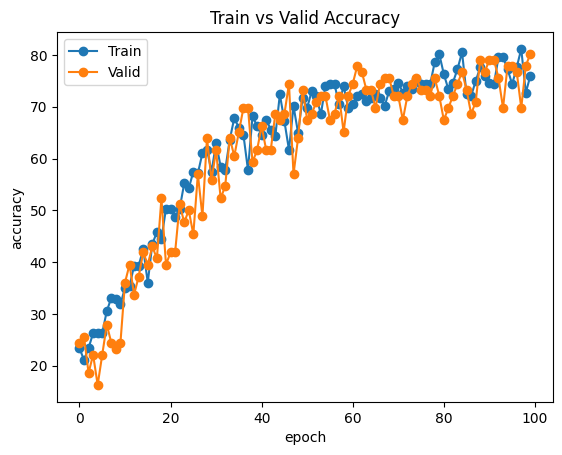

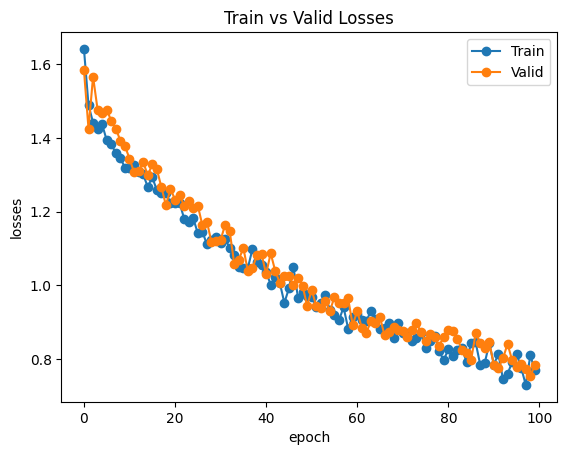

In [19]:
EPOCHS = 100

best_valid_loss = float('inf')
best_val_acc = 0.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_acc_gr = []
train_loss_gr = []
val_acc_gr = []
val_loss_gr = []

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc, train_acc_gr, train_loss_gr = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, val_acc_gr, val_loss_gr = evaluate(model, val_loader, criterion, device)
    
    if epoch % 30 == 0:
        checkpoint_model(epoch, model, optimizer, best_val_acc, '/kaggle/working/CNN_epoch%d.pth' % epoch)


    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


plt.plot(train_acc_gr,'-o')
plt.plot(val_acc_gr,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

plt.plot(train_loss_gr,'-o')
plt.plot(val_loss_gr,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
plt.show()

In [20]:
epoch_loss = 0
epoch_acc = 0
image_preds_all = []
image_targets_all = []

model.eval()

with torch.no_grad():

    for (x, y) in tqdm(val_loader, desc="Evaluating", leave=False):

        x = x.to(device).float()
        y = y.to(device).long()

        y_pred = model(x)

        image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
        image_targets_all += [y.detach().cpu().numpy()]

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

image_preds_all = np.concatenate(image_preds_all)
image_targets_all = np.concatenate(image_targets_all)
score = (image_preds_all==image_targets_all).mean()

performance_matrix(image_targets_all, image_preds_all)

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Precision: 0.7939 Recall: 0.7945, Accuracy: 0.7907: ,f1_score: 0.7898
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77        23
           1       0.83      0.68      0.75        22
           2       0.75      0.90      0.82        20
           3       0.78      0.86      0.82        21

    accuracy                           0.79        86
   macro avg       0.79      0.79      0.79        86
weighted avg       0.80      0.79      0.79        86



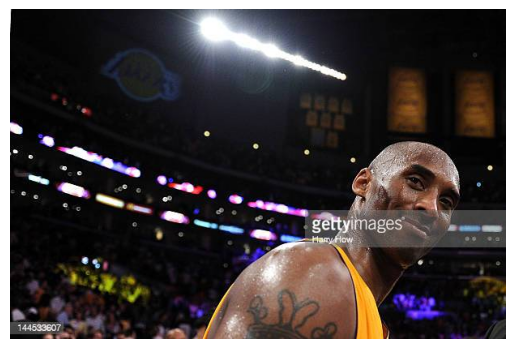

In [36]:
import matplotlib.pyplot as plt
from PIL import Image  # PIL is used to handle image loading

# Define the path to the image file in your output folder
image_path = '/kaggle/working/data1/test/Kobe Bryant/kobe_(67).jpg'

# Load the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [37]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Define the transformations for the input image
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Load the image from its path
image_path = "/kaggle/working/data1/test/Kobe Bryant/kobe_(67).jpg"  # Replace this with the actual image path
image = Image.open(image_path).convert("RGB")

# Apply the transformations to the image
input_image = test_transform(image).unsqueeze(0)  # Add batch dimension

# Move the input image to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_image = input_image.to(device)

# Perform the inference to get the predictions
with torch.no_grad():
    model.eval()
    output = model(input_image)
    predicted_class = torch.argmax(output, 1).item()

# Convert the predicted class index to a human-readable label
# Assuming you have a list of class names like ['class1', 'class2', 'class3', 'class4']
class_names = ['Kane Williamson', 'Kobe Bryant', 'Maria Sharapova', 'Ronaldo']  # Replace with your actual class names
predicted_label = class_names[predicted_class]

print("Predicted Class:", predicted_label)

Predicted Class: Kobe Bryant
